<a href="https://colab.research.google.com/github/OVP2023/ML/blob/main/dz1_Digit_Recognizer_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
#Digit Recognizer
#https://www.kaggle.com/c/digit-recognizer

%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt


train = np.loadtxt('/content/drive/MyDrive/Datasets/CV/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/content/drive/MyDrive/Datasets/CV/digit/test.csv', delimiter=',', skiprows=1)

# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))


In [22]:
train_img.shape

(42000, 28, 28)

In [23]:
#Визуализируем исходные данные  Вверху над изображением номер класса (для цифр от 0 до 9) к которому данное изображение относится, типа метки

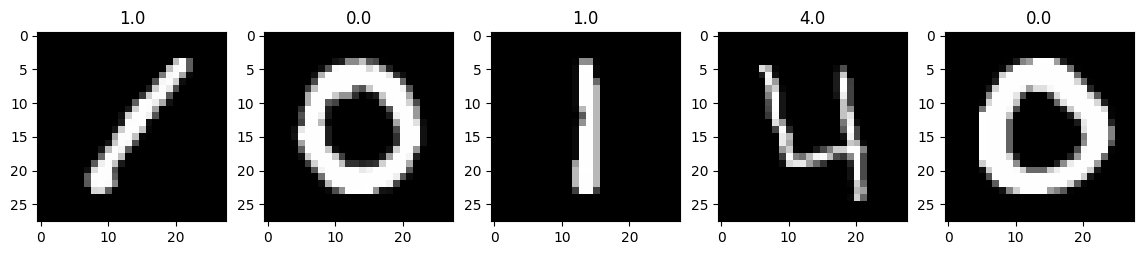

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [24]:
#Вычисляем X и Y составляющие градиента с помощью оператора Собеля

train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)



test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)


In [25]:
#Вычисляем угол и длину вектора градиента  Для этого делаем переход от координат Х,У к полярным (ро-тетта)

train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

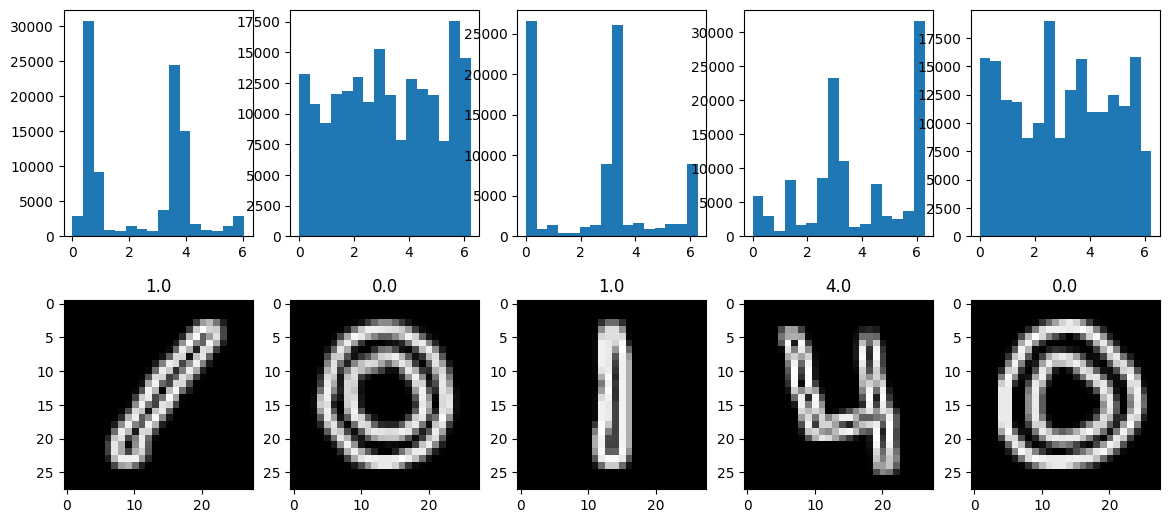

In [26]:
#Строим гистограммы градиентов для каждого изображения цифр
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())


In [27]:
#Вычисляем гистограммы градиентов
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [28]:
#Нормируем вектор гистограммы
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [35]:
#Решаем задачу классификации
#Разбиваем выборку на обучение и валидацию
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)



In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
pred_val = rf_model.predict(x_val)
print(accuracy_score(y_val, pred_val))

0.6478571428571429


In [120]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.43      0.40      0.41       816
         1.0       0.98      0.96      0.97       909
         2.0       0.50      0.46      0.48       846
         3.0       0.66      0.71      0.68       937
         4.0       0.72      0.71      0.71       839
         5.0       0.65      0.67      0.66       702
         6.0       0.47      0.46      0.47       785
         7.0       0.86      0.79      0.83       893
         8.0       0.50      0.57      0.53       835
         9.0       0.66      0.71      0.68       838

    accuracy                           0.65      8400
   macro avg       0.64      0.64      0.64      8400
weighted avg       0.65      0.65      0.65      8400



In [119]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc_model = SVC()
svc_model.fit(x_train, y_train)
pred_svc = svc_model.predict(x_val)
print(accuracy_score(y_val, pred_svc))

0.6529761904761905


In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_svc))  # По результату f1-score лучше всего у нас распознаются 1 (0.96), хуже 0 (0.44)

              precision    recall  f1-score   support

         0.0       0.44      0.44      0.44       816
         1.0       0.97      0.95      0.96       909
         2.0       0.50      0.46      0.48       846
         3.0       0.67      0.70      0.68       937
         4.0       0.72      0.71      0.72       839
         5.0       0.62      0.66      0.64       702
         6.0       0.49      0.48      0.48       785
         7.0       0.87      0.80      0.84       893
         8.0       0.53      0.59      0.56       835
         9.0       0.69      0.69      0.69       838

    accuracy                           0.65      8400
   macro avg       0.65      0.65      0.65      8400
weighted avg       0.66      0.65      0.65      8400



In [141]:
#Предсказания на тестовых данных

test_pred_svc = svc_model.predict(test_hist)
result_svc = pd.DataFrame({'ImageId': range(1, len(test)+1), 'Label': test_pred_svc})
result_svc

,ImageId,Label
0,1,2.0
1,2,5.0
2,3,9.0
3,4,0.0
4,5,3.0
...,...,...
27995,27996,9.0
27996,27997,7.0
27997,27998,3.0
27998,27999,9.0


In [150]:
result_svc['Label']=result_svc['Label'].astype(int)

In [151]:
result_svc.to_csv('submit.csv', index=False)

In [152]:
!head submit.csv

ImageId,Label
1,2
2,5
3,9
4,0
5,3
6,7
7,0
8,3
9,8
